# Step-by-Step per-wave Calculation Demonstration (using scipy.signal.find_peaks)

This notebook demonstrates the core logic of the `analyze_slow_wave` function from the EEG analysis pipeline, using `scipy.signal.find_peaks`. It processes a single slow wave CSV file step-by-step, visualizing the intermediate results.

## 1. Setup

Import necessary libraries and define helper functions.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from pathlib import Path
import warnings
from scipy.signal import find_peaks # Import find_peaks

# Define the region extraction function (copied from utils.py)
def extract_region_name(full_name):
    """Extract anatomical region name from the full voxel name."""
    try:
        # Simple case: 'Region.VoxelName'
        if '.' in full_name and not "['" in full_name:
            return full_name.split('.')[0]
        # Case like "AtlasName['Region.SubRegion'].VoxelName" or similar
        elif "['" in full_name and "." in full_name:
            # Extract content within ['...']
            content_in_brackets = full_name.split("['")[1].split("']")[0]
            # Take the part before the first dot within the brackets if it exists
            if '.' in content_in_brackets:
                 return content_in_brackets.split('.')[0]
            else:
                 return content_in_brackets # Return the whole content if no dot
        # Fallback if no known pattern matches
        else:
            return full_name
    except Exception as e:
        print(f"Error extracting region from {full_name}: {e}")
        return full_name # Return original name on error

plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported and helper function defined.")

Libraries imported and helper function defined.


## 2. User Input: Specify Wave Data File

Enter the full path to the specific slow wave CSV file you want to analyze.

In [2]:
csv_file_path_str = input("Enter the path to the slow wave CSV file: ")
csv_file_path = Path(csv_file_path_str.strip()) # Use strip() to remove leading/trailing whitespace

# Basic validation
if not csv_file_path.is_file():
    print(f"\033[91mError: File not found at {csv_file_path}\033[0m") # Red text for error
    # Optionally raise an error to stop execution
    # raise FileNotFoundError(f"File not found at {csv_file_path}") 
else:
    wave_name = csv_file_path.stem
    print(f"Processing wave: {wave_name}")

Processing wave: proto1_post-stim_sw103_E3_scouts


## 3. Load and Prepare Data

Read the CSV file into a pandas DataFrame. Parse the time points (converting from seconds to milliseconds) and voxel names. We also take the absolute value of the data, as the analysis focuses on the magnitude of activity.

CSV loaded successfully.
Detected format with 'Time' column.

Data shape: (14399, 51) (voxels, time points)
Time points range (ms): -50.0 to 50.0
Number of voxels: 14399

Raw Data Head:


,Time,-0.05,-0.048,-0.046,-0.044,-0.042,-0.04,-0.038,-0.036,-0.034,...,0.034,0.036,0.038,0.04,0.042,0.044,0.046,0.048,0.05,Unnamed: 52
0,caudalanteriorcingulate L.4145,1.399367e-08,1.391985e-08,1.384079e-08,1.375651e-08,1.366706e-08,1.357248e-08,1.347282e-08,1.336813e-08,1.325845e-08,...,7.048233e-09,6.809831e-09,6.569365e-09,6.326942e-09,6.082660e-09,5.836621e-09,5.588931e-09,5.339695e-09,5.089015e-09,NaN
1,caudalanteriorcingulate L.4278,2.100959e-09,2.272780e-09,2.443305e-09,2.612464e-09,2.780201e-09,2.946465e-09,3.111193e-09,3.274333e-09,3.435827e-09,...,7.604240e-09,7.679604e-09,7.751907e-09,7.821137e-09,7.887264e-09,7.950279e-09,8.010166e-09,8.066910e-09,8.120496e-09,NaN
2,caudalanteriorcingulate L.4282,-1.162274e-08,-1.152035e-08,-1.141432e-08,-1.130470e-08,-1.119154e-08,-1.107490e-08,-1.095482e-08,-1.083137e-08,-1.070459e-08,...,-4.887187e-09,-4.687422e-09,-4.486979e-09,-4.285948e-09,-4.084411e-09,-3.882445e-09,-3.680142e-09,-3.477580e-09,-3.274843e-09,NaN
3,caudalanteriorcingulate L.4319,1.249605e-09,1.345820e-09,1.440577e-09,1.533817e-09,1.625509e-09,1.715604e-09,1.804071e-09,1.890862e-09,1.975937e-09,...,3.616867e-09,3.623159e-09,3.626866e-09,3.627990e-09,3.626519e-09,3.622452e-09,3.615787e-09,3.606527e-09,3.594667e-09,NaN
4,caudalanteriorcingulate L.4321,9.585274e-09,9.384039e-09,9.180284e-09,8.974081e-09,8.765513e-09,8.554650e-09,8.341581e-09,8.126379e-09,7.909124e-09,...,-9.212563e-11,-3.273834e-10,-5.616119e-10,-7.947327e-10,-1.026659e-09,-1.257318e-09,-1.486627e-09,-1.714507e-09,-1.940880e-09,NaN


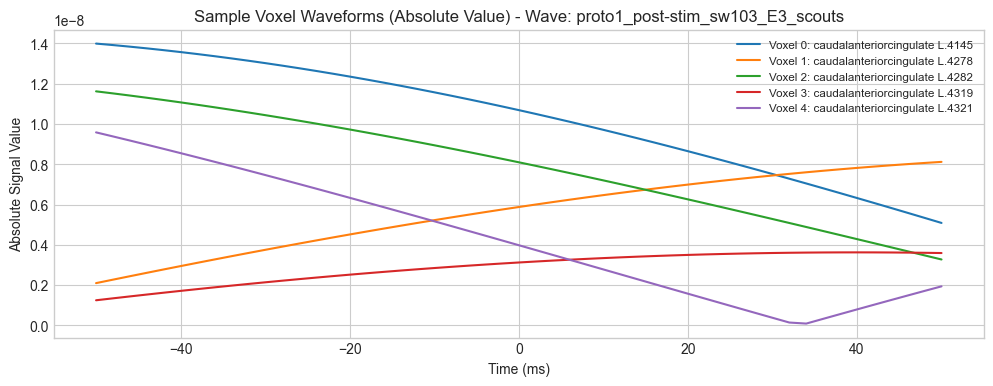

In [3]:
if 'csv_file_path' in locals() and csv_file_path.is_file():
    try:
        df = pd.read_csv(csv_file_path)
        print("CSV loaded successfully.")

        # --- Data Parsing Logic (adapted from analyze_slow_wave) ---
        if 'Time' in df.columns:
            print("Detected format with 'Time' column.")
            # Format with 'Time' column first
            numeric_cols = []
            for col in df.columns[1:]:
                # Ignore potential unnamed columns from index saving
                if not str(col).startswith('Unnamed'):
                    try:
                        # Test if column header can be converted to float (represents time)
                        float(col) 
                        numeric_cols.append(col)
                    except ValueError:
                        print(f"  Skipping non-numeric column: {col}")
                        continue
            time_points_sec = np.array([float(t) for t in numeric_cols])
            # Select only the numeric time columns for data
            data = df.loc[:, numeric_cols].values 
            voxel_names = df.iloc[:, 0].values
        else:
             # Try inferring format without 'Time' column
             print("Attempting to infer format without 'Time' column.")
             # Assume first column is voxel names, rest are time points
             numeric_cols = []
             for col in df.columns[1:]:
                 if not str(col).startswith('Unnamed'):
                     try:
                         float(col)
                         numeric_cols.append(col)
                     except ValueError:
                         print(f"  Skipping non-numeric column: {col}")
                         continue
             if not numeric_cols:
                 raise ValueError("Could not find numeric time columns after the first column.")
             
             time_points_sec = np.array([float(t) for t in numeric_cols])
             data = df.loc[:, numeric_cols].values
             voxel_names = df.iloc[:, 0].values
             print("Assumed first column is voxel name, subsequent numeric columns are time.")

        # Convert time to milliseconds and take absolute value of data
        time_points_ms = time_points_sec * 1000 
        abs_data = np.abs(data) 

        print(f"\nData shape: {data.shape} (voxels, time points)")
        print(f"Time points range (ms): {time_points_ms.min():.1f} to {time_points_ms.max():.1f}")
        print(f"Number of voxels: {len(voxel_names)}")

        # --- Visualization: Raw Data Snippet ---
        print("\nRaw Data Head:")
        display(df.head())

        # --- Visualization: Sample Waveforms (Absolute Values) ---
        num_voxels_to_plot = min(5, abs_data.shape[0]) # Plot up to 5 voxels
        plt.figure(figsize=(12, 4))
        for i in range(num_voxels_to_plot):
            plt.plot(time_points_ms, abs_data[i, :], label=f'Voxel {i}: {voxel_names[i]}')
        
        plt.title(f'Sample Voxel Waveforms (Absolute Value) - Wave: {wave_name}')
        plt.xlabel('Time (ms)')
        plt.ylabel('Absolute Signal Value')
        plt.legend(loc='upper right', fontsize='small')
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"\033[91mError loading or parsing CSV: {e}\033[0m")
        # Clear potentially partially defined variables
        if 'df' in locals(): del df
        if 'data' in locals(): del data
        if 'abs_data' in locals(): del abs_data
        if 'time_points_ms' in locals(): del time_points_ms
        if 'voxel_names' in locals(): del voxel_names
else:
    print("\033[91mCannot proceed: CSV file path is not valid or file not found.\033[0m")

## 4. Apply Time Window

Select the data only within the specified time window (-50ms to +50ms). This focuses the analysis on the core part of the slow wave.

Windowed data shape: (14399, 51) (voxels, time points in window)
Windowed time points range (ms): -50.0 to 50.0


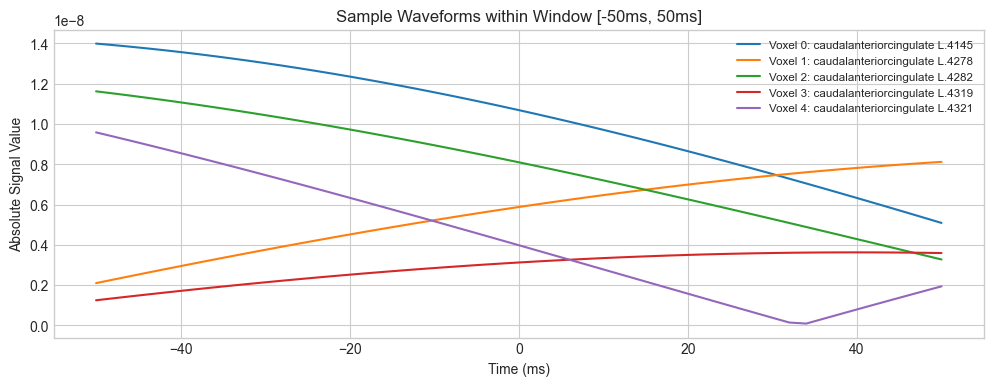

In [4]:
if 'time_points_ms' in locals() and 'abs_data' in locals():
    window_start_ms = -50
    window_end_ms = 50
    window_mask = (time_points_ms >= window_start_ms) & (time_points_ms <= window_end_ms)

    if sum(window_mask) == 0:
        print(f"\033[93mWarning: No time points found in window [{window_start_ms}, {window_end_ms}] ms. Using full time range as fallback.\033[0m")
        window_mask = np.ones_like(time_points_ms, dtype=bool) # Fallback to using all points

    # Apply the mask to data and time points
    windowed_data = abs_data[:, window_mask]
    windowed_times_ms = time_points_ms[window_mask]

    print(f"Windowed data shape: {windowed_data.shape} (voxels, time points in window)")
    if windowed_times_ms.size > 0:
        print(f"Windowed time points range (ms): {windowed_times_ms.min():.1f} to {windowed_times_ms.max():.1f}")
    else:
        print("Windowed time points: None (empty window)")

    # --- Visualization: Windowed Waveforms ---
    plt.figure(figsize=(12, 4))
    num_voxels_to_plot = min(5, windowed_data.shape[0])
    for i in range(num_voxels_to_plot):
        plt.plot(windowed_times_ms, windowed_data[i, :], label=f'Voxel {i}: {voxel_names[i]}')
    
    plt.title(f'Sample Waveforms within Window [{window_start_ms}ms, {window_end_ms}ms]')
    plt.xlabel('Time (ms)')
    plt.ylabel('Absolute Signal Value')
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.show()
else:
    print("\033[91mCannot proceed: Required variables ('time_points_ms', 'abs_data') not defined from previous step.\033[0m")

## 5. Calculate Threshold

Determine the activity threshold. This is calculated dynamically as a percentage (default 25%) of the maximum absolute signal value found across *all* voxels within the time window.

Max absolute value in window [-50ms, 50ms]: 5.129846e-08
Calculated threshold (25%): 1.2824615593e-08


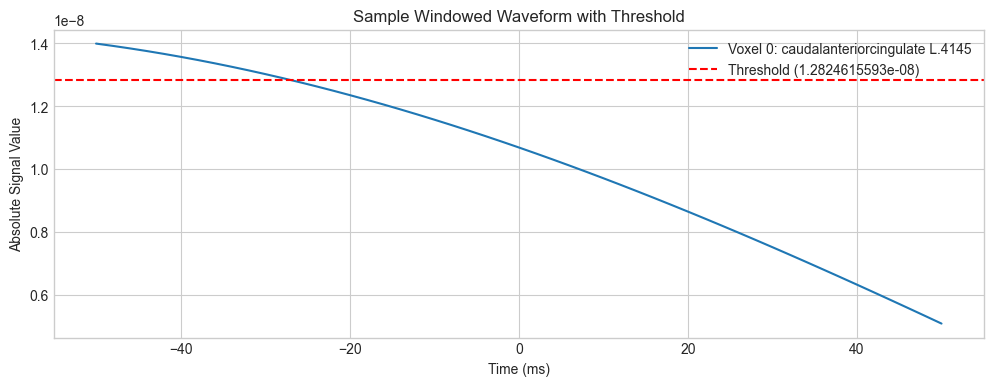

In [5]:
if 'windowed_data' in locals():
    threshold_percent = 25
    
    if windowed_data.size > 0:
        max_current_in_window = np.max(windowed_data)
        threshold = max_current_in_window * (threshold_percent / 100.0)
    else:
        max_current_in_window = 0
        threshold = 0
        print("\033[93mWarning: Windowed data is empty, threshold set to 0.\033[0m")

    # Use scientific notation for potentially very small numbers
    print(f"Max absolute value in window [{window_start_ms}ms, {window_end_ms}ms]: {max_current_in_window:.6e}")
    print(f"Calculated threshold ({threshold_percent}%): {threshold:.10e}")

    # --- Visualization: Threshold on Sample Waveform ---
    if windowed_data.size > 0:
        plt.figure(figsize=(12, 4))
        # Plot the first voxel's windowed data as an example
        voxel_to_plot_idx = 0
        plt.plot(windowed_times_ms, windowed_data[voxel_to_plot_idx, :], label=f'Voxel {voxel_to_plot_idx}: {voxel_names[voxel_to_plot_idx]}')
        # Draw the threshold line
        plt.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.10e})')
        
        plt.title(f'Sample Windowed Waveform with Threshold')
        plt.xlabel('Time (ms)')
        plt.ylabel('Absolute Signal Value')
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.show()
    else:
        print("Cannot visualize threshold: Windowed data is empty.")
else:
    print("\033[91mCannot proceed: Required variable ('windowed_data') not defined from previous step.\033[0m")

## 6. Detect Peaks and Voxel Involvement (using scipy.signal.find_peaks)

For each voxel:
1. Use `scipy.signal.find_peaks` to find all peaks within the time window that are **above** the calculated `threshold`.
2. If peaks above the threshold exist, find the one that occurs earliest in time.
3. A voxel is considered "involved" if it has at least one peak above the threshold within the window. The time of the *first* such peak is recorded.

Finally, calculate the total number and percentage of involved voxels.

Total voxels: 14399
Involved voxels (peak > threshold in window): 1445
Involvement Percentage: 10.04%

First few involved voxels and their first peak times:


,voxel_index,full_name,peak_time_ms
0,86,caudalanteriorcingulate L.5352,16.0
1,90,caudalanteriorcingulate L.5418,-10.0
2,154,caudalanteriorcingulate R.12567,-4.0
3,160,caudalanteriorcingulate R.12630,-38.0
4,164,caudalanteriorcingulate R.12668,-10.0


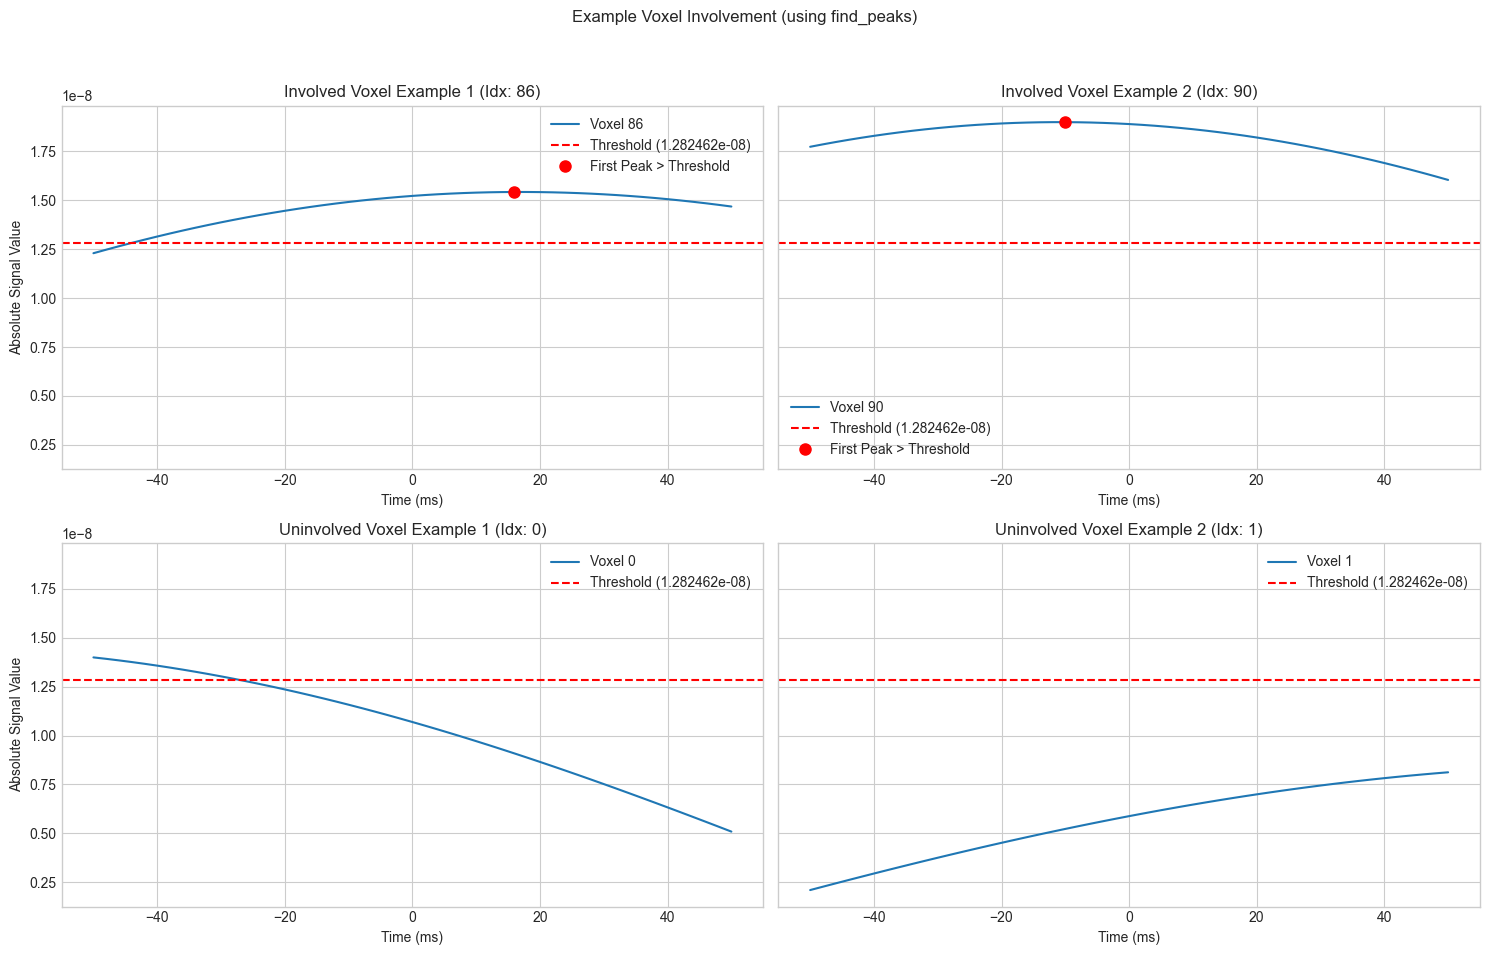

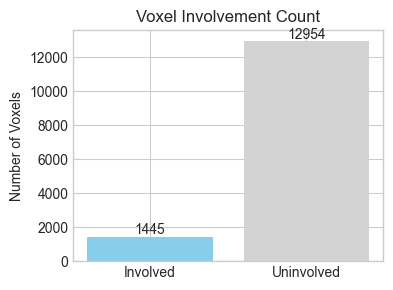

In [6]:
if 'windowed_data' in locals() and 'threshold' in locals():
    voxel_peak_times = [] # Stores info for involved voxels
    involved_voxels_indices = []
    example_involved_indices = [] # Store indices for visualization
    example_uninvolved_indices = []
    involved_peak_info = {} # Store peak info for involved examples

    # Iterate through each voxel
    for voxel_idx in range(windowed_data.shape[0]):
        voxel_data = windowed_data[voxel_idx]
        peaks_above_threshold = [] # Store (time, value) tuples for this voxel

        # Use scipy.signal.find_peaks with the height parameter
        peak_indices, _ = find_peaks(voxel_data, height=threshold)
        
        if peak_indices.size > 0:
            # Get the times and values for the found peaks
            peak_times = windowed_times_ms[peak_indices]
            peak_values = voxel_data[peak_indices]
            peaks_above_threshold = list(zip(peak_times, peak_values))
        
        # If any peaks were found above the threshold for this voxel
        if peaks_above_threshold:
            # Find the peak that occurred earliest in time
            first_peak = min(peaks_above_threshold, key=lambda x: x[0])
            first_peak_time_ms = first_peak[0]
            first_peak_value = first_peak[1]
            
            # Record voxel info
            voxel_peak_times.append({
                'voxel_index': voxel_idx,
                'full_name': voxel_names[voxel_idx],
                'peak_time_ms': first_peak_time_ms
                # Optionally add 'peak_value': first_peak_value
            })
            involved_voxels_indices.append(voxel_idx)
            
            # Store info for the first two involved voxels found (for visualization)
            if len(example_involved_indices) < 2:
                example_involved_indices.append(voxel_idx)
                involved_peak_info[voxel_idx] = {'time': first_peak_time_ms, 'value': first_peak_value}
        else:
             # Store index of the first two uninvolved voxels found (for visualization)
             if len(example_uninvolved_indices) < 2:
                 example_uninvolved_indices.append(voxel_idx)

    # --- Calculate Involvement Statistics ---
    total_voxels = abs_data.shape[0]
    involvement_count = len(involved_voxels_indices)
    involvement_percentage = (involvement_count / total_voxels) * 100 if total_voxels > 0 else 0

    print(f"Total voxels: {total_voxels}")
    print(f"Involved voxels (peak > threshold in window): {involvement_count}")
    print(f"Involvement Percentage: {involvement_percentage:.2f}%")

    # Create DataFrame for easier handling of involved voxels
    involved_voxels_df = pd.DataFrame(voxel_peak_times)
    if not involved_voxels_df.empty:
        print("\nFirst few involved voxels and their first peak times:")
        display(involved_voxels_df.head())
    else:
        print("\nNo voxels were involved in this wave.")

    # --- Visualization: Involved vs. Uninvolved Examples (2 each) ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharey=True)
    fig.suptitle('Example Voxel Involvement (using find_peaks)')

    # Plot involved examples
    for i, idx in enumerate(example_involved_indices):
        ax = axes[0, i]
        ax.plot(windowed_times_ms, windowed_data[idx, :], label=f'Voxel {idx}')
        ax.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.6e})')
        peak_info = involved_peak_info[idx]
        ax.plot(peak_info['time'], peak_info['value'], 'ro', markersize=8, label='First Peak > Threshold')
        ax.set_title(f'Involved Voxel Example {i+1} (Idx: {idx})')
        ax.set_xlabel('Time (ms)')
        if i == 0:
            ax.set_ylabel('Absolute Signal Value')
        ax.legend()
        ax.grid(True)
    # Fill remaining involved plots if fewer than 2 found
    for i in range(len(example_involved_indices), 2):
        axes[0, i].set_title(f'Involved Voxel Example {i+1} (N/A)')
        axes[0, i].text(0.5, 0.5, 'Less than 2 involved voxels found', ha='center', va='center', transform=axes[0, i].transAxes)
        axes[0, i].set_xlabel('Time (ms)')

    # Plot uninvolved examples
    for i, idx in enumerate(example_uninvolved_indices):
        ax = axes[1, i]
        ax.plot(windowed_times_ms, windowed_data[idx, :], label=f'Voxel {idx}')
        ax.axhline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.6e})')
        ax.set_title(f'Uninvolved Voxel Example {i+1} (Idx: {idx})')
        ax.set_xlabel('Time (ms)')
        if i == 0:
            ax.set_ylabel('Absolute Signal Value')
        ax.legend()
        ax.grid(True)
    # Fill remaining uninvolved plots if fewer than 2 found
    for i in range(len(example_uninvolved_indices), 2):
        axes[1, i].set_title(f'Uninvolved Voxel Example {i+1} (N/A)')
        axes[1, i].text(0.5, 0.5, 'Less than 2 uninvolved voxels found', ha='center', va='center', transform=axes[1, i].transAxes)
        axes[1, i].set_xlabel('Time (ms)')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

    # --- Visualization: Involvement Bar Chart ---
    plt.figure(figsize=(4, 3))
    labels = ['Involved', 'Uninvolved']
    counts = [involvement_count, total_voxels - involvement_count]
    plt.bar(labels, counts, color=['skyblue', 'lightgray'])
    plt.title('Voxel Involvement Count')
    plt.ylabel('Number of Voxels')
    for i, count in enumerate(counts):
        plt.text(i, count + 0.01 * total_voxels, str(count), ha='center') # Add counts on bars
    plt.show()

else:
    print("\033[91mCannot proceed: Required variables ('windowed_data', 'threshold') not defined from previous step.\033[0m")

## 7. Map Voxels to Regions

Use the `extract_region_name` helper function to simplify the detailed voxel names (e.g., `Frontal_Sup_L.Source001`) to their corresponding anatomical region names (e.g., `Frontal_Sup_L`) for all *involved* voxels.

In [7]:
if 'involved_voxels_df' in locals() and not involved_voxels_df.empty:
    # Apply the function to the 'full_name' column to create a new 'region' column
    involved_voxels_df['region'] = involved_voxels_df['full_name'].apply(extract_region_name)
    print("\nInvolved voxels DataFrame with extracted regions:")
    display(involved_voxels_df.head())
elif 'involved_voxels_df' in locals():
     print("\nNo involved voxels to map to regions.")
else:
    print("\033[91mCannot proceed: Required variable ('involved_voxels_df') not defined from previous step.\033[0m")


Involved voxels DataFrame with extracted regions:


,voxel_index,full_name,peak_time_ms,region
0,86,caudalanteriorcingulate L.5352,16.0,caudalanteriorcingulate L
1,90,caudalanteriorcingulate L.5418,-10.0,caudalanteriorcingulate L
2,154,caudalanteriorcingulate R.12567,-4.0,caudalanteriorcingulate R
3,160,caudalanteriorcingulate R.12630,-38.0,caudalanteriorcingulate R
4,164,caudalanteriorcingulate R.12668,-10.0,caudalanteriorcingulate R


## 8. Identify Origin Regions

The "origins" of the slow wave are defined as the set of regions corresponding to the involved voxels that showed the earliest activity (i.e., had the earliest first peak time above threshold).

1. Sort the involved voxels by their `peak_time_ms`.
2. Select the top 10% of these sorted voxels (with a minimum of 1 voxel).
3. The unique regions associated with these earliest voxels are considered the origin regions.


Identifying origins (earliest 144 involved voxels based on peak time):


,full_name,region,peak_time_ms
535,medialorbitofrontal R.12878,medialorbitofrontal R,-48.0
147,fusiform R.10653,fusiform R,-48.0
1101,superiorfrontal R.13366,superiorfrontal R,-48.0
202,inferiorparietal L.7393,inferiorparietal L,-48.0
225,inferiortemporal L.2101,inferiortemporal L,-48.0
...,...,...,...
1086,superiorfrontal R.13248,superiorfrontal R,-40.0
1265,superiorparietal L.6625,superiorparietal L,-40.0
756,parahippocampal R.10699,parahippocampal R,-40.0
769,parahippocampal R.14304,parahippocampal R,-40.0



Unique Origin Regions (29): ['caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'fusiform R', 'inferiorparietal L', 'inferiortemporal L', 'inferiortemporal R', 'insula R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral R', 'parahippocampal R', 'parsopercularis R', 'precuneus L', 'rostralanteriorcingulate L', 'rostralanteriorcingulate R', 'rostralmiddlefrontal R', 'superiorfrontal L', 'superiorfrontal R', 'superiorparietal L', 'superiortemporal L', 'superiortemporal R']


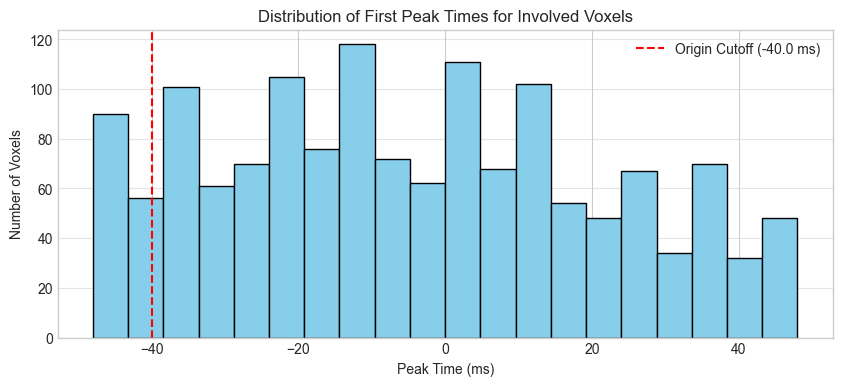

In [8]:
# Initialize origins_df to None or empty DataFrame
origins_df = pd.DataFrame()
origin_regions = []

if 'involved_voxels_df' in locals() and not involved_voxels_df.empty:
    # Sort involved voxels by peak time
    sorted_involved_df = involved_voxels_df.sort_values('peak_time_ms')

    # Determine the number of origins (earliest 10%, minimum 1)
    n_origins = max(1, int(len(sorted_involved_df) * 0.1))

    # Select the earliest voxels as origins
    origins_df = sorted_involved_df.head(n_origins).copy() # Use .copy() to avoid SettingWithCopyWarning

    print(f"\nIdentifying origins (earliest {n_origins} involved voxels based on peak time):")
    display(origins_df[['full_name', 'region', 'peak_time_ms']])

    # Get the unique regions from the origins DataFrame
    origin_regions = sorted(list(origins_df['region'].unique()))
    print(f"\nUnique Origin Regions ({len(origin_regions)}): {origin_regions}")
    
    # --- Visualization: Peak Time Distribution ---
    plt.figure(figsize=(10, 4))
    plt.hist(involved_voxels_df['peak_time_ms'], bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of First Peak Times for Involved Voxels')
    plt.xlabel('Peak Time (ms)')
    plt.ylabel('Number of Voxels')
    
    # Add a vertical line indicating the cutoff for origins
    if not origins_df.empty:
        cutoff_time = origins_df['peak_time_ms'].max()
        plt.axvline(cutoff_time, color='r', linestyle='--', label=f'Origin Cutoff ({cutoff_time:.1f} ms)')
        plt.legend()
        
    plt.grid(axis='y', alpha=0.5)
    plt.show()

elif 'involved_voxels_df' in locals():
     print("\nNo involved voxels, cannot identify origins.")
else:
    print("\033[91mCannot proceed: Required variable ('involved_voxels_df') not defined from previous step.\033[0m")

## 9. Summary of Results

Display the key metrics calculated for this specific wave.

In [9]:
print("\n" + "="*30)
print(f"   Summary for Wave: {wave_name}")
print("="*30)

# Check if variables exist before printing
if 'involvement_percentage' in locals() and 'involvement_count' in locals() and 'total_voxels' in locals():
    print(f"- Involvement:      {involvement_percentage:.2f}% ({involvement_count} / {total_voxels} voxels)")
else:
    print("- Involvement:      Not calculated (error in previous steps)")

if 'origin_regions' in locals():
    if origin_regions: # Check if the list is not empty
        print(f"- Origin Regions:   {len(origin_regions)} unique regions")
        # Optionally print the list, wrap if long
        regions_str = ', '.join(origin_regions)
        max_len = 70
        if len(regions_str) > max_len:
             print(f"                    {regions_str[:max_len]}...")
        else:
             print(f"                    {regions_str}")
        # Display origin details DataFrame again if needed
        # print("\nOrigin Voxel Details:")
        # display(origins_df[['region', 'peak_time_ms']])
    else:
        # Handle case where involved_voxels_df existed but was empty, or origins_df ended up empty
        if 'involved_voxels_df' in locals() and involved_voxels_df.empty:
             print("- Origin Regions:   None (no involved voxels)")
        else:
             print("- Origin Regions:   None (involved voxels found, but origin calculation might have yielded none - check logic or data)")
else:
    print("- Origin Regions:   Not calculated (error in previous steps)")

if 'window_start_ms' in locals() and 'window_end_ms' in locals():
    print(f"- Analysis Window:  {window_start_ms}ms to {window_end_ms}ms")
else:
    print("- Analysis Window:  Not set (error in previous steps)")

if 'threshold' in locals():
    print(f"- Threshold Value:  {threshold:.10e}")
else:
    print("- Threshold Value:  Not calculated (error in previous steps)")

print("="*30)


   Summary for Wave: proto1_post-stim_sw103_E3_scouts
- Involvement:      10.04% (1445 / 14399 voxels)
- Origin Regions:   29 unique regions
                    caudalanteriorcingulate R, caudalmiddlefrontal L, caudalmiddlefrontal ...
- Analysis Window:  -50ms to 50ms
- Threshold Value:  1.2824615593e-08
